In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from qibolab.platforms.multiqubit import MultiqubitPlatform
from qibolab.pulses import Pulse, ReadoutPulse, PulseSequence
from qibolab.paths import qibolab_folder

In [6]:
runcard = qibolab_folder / "runcards" / "icarusqfpga.yml"
platform = MultiqubitPlatform("icarusq", runcard)

[Qibo 0.1.8rc1.dev0|INFO|2022-08-23 12:22:24]: Loading platform icarusq from runcard c:\qibolab\src\qibolab\runcards\icarusqfpga.yml


In [16]:
PULSE_AMPLITUDE = 8191
PULSE_SHAPE = "Rectangular()"

READOUT_FREQUENCY = 4.86655e9
READOUT_DURATION = 5000
READOUT_CHANNEL = "i6"
READOUT_PHASE = 0

QUBIT_CHANNEL = "x3"
QUBIT_FREQUENCY = 3.833e9
QUBIT_PHASE = 0
QUBIT = 0

In [8]:
platform.connect()
platform.setup()

[Qibo 0.1.8rc1.dev0|INFO|2022-08-23 12:23:00]: Connecting to icarusq instrument board0.


### Readout Frequency Sweep

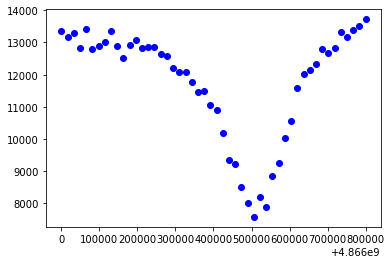

In [40]:
readout_frequency_start = 4.866e9
readout_frequency_end = 4.8668e9
sweep = np.linspace(readout_frequency_start, readout_frequency_end, 50)
results = np.zeros(len(sweep))
k = 0

for freq in sweep:
    
    ro_pulse = ReadoutPulse(start=0, duration=READOUT_DURATION, amplitude=PULSE_AMPLITUDE, frequency=freq,
                            phase=READOUT_PHASE, shape=PULSE_SHAPE, channel=READOUT_CHANNEL, qubit=QUBIT)
    ps = PulseSequence()
    ps.add(ro_pulse)

    res = platform.execute_pulse_sequence(ps, 1000)
    results[k] = res[0][0]
    plt.scatter(freq, res[0][0], color="blue")
    k += 1
    display.display(plt.gcf())
    display.clear_output(wait=True)

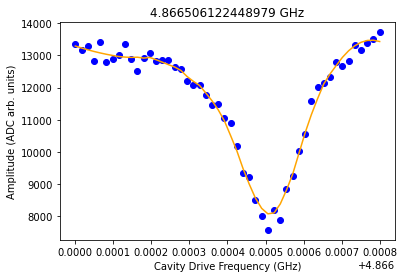

In [41]:
%matplotlib inline

from scipy.signal import savgol_filter
plt.figure()
plt.scatter(sweep/1e9, results, color="blue")
smooth_data = savgol_filter(results, 15, 2)
plt.plot(sweep/1e9, smooth_data, color="orange")
ro_f = sweep[smooth_data.argmin()] / 1e9
plt.xlabel("Cavity Drive Frequency (GHz)")
plt.ylabel("Amplitude (ADC arb. units)")
plt.title(f"{ro_f} GHz")
READOUT_FREQUENCY = ro_f * 1e9
plt.savefig("FPGA_cavity_sweep.png", dpi=300)
plt.show()

### Rabi Spectroscopy

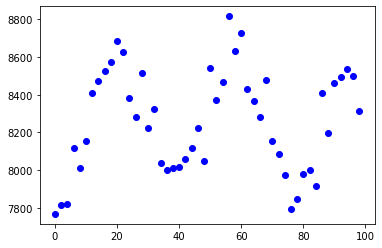

In [42]:
pulse_length_sweep_start = 0
pulse_length_sweep_end = 100
pulse_length_sweep_step = 2
pulse_length_sweep = np.arange(pulse_length_sweep_start, pulse_length_sweep_end, pulse_length_sweep_step)
rabi_results = np.zeros(len(pulse_length_sweep))

for idx, pulse_length in enumerate(pulse_length_sweep):
    rabi_pulse = Pulse(start=0, duration=pulse_length, amplitude=PULSE_AMPLITUDE, frequency=QUBIT_FREQUENCY,
                       phase=QUBIT_PHASE, shape=PULSE_SHAPE, channel=QUBIT_CHANNEL, qubit=QUBIT)
    ro_pulse = ReadoutPulse(start=pulse_length, duration=READOUT_DURATION, amplitude=PULSE_AMPLITUDE, frequency=READOUT_FREQUENCY,
                            phase=READOUT_PHASE, shape=PULSE_SHAPE, channel=READOUT_CHANNEL, qubit=QUBIT)
    ps = PulseSequence()
    ps.add(rabi_pulse)
    ps.add(ro_pulse)

    res = platform.execute_pulse_sequence(ps, 2000)
    rabi_results[idx] = res[0][0]
    plt.scatter(pulse_length, res[0][0], color="blue")
    display.display(plt.gcf())
    display.clear_output(wait=True)

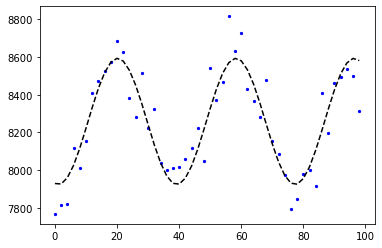

In [46]:
from scipy.optimize import curve_fit

def rabi(x, *p) :
    # A fit to Superconducting Qubit Rabi Oscillation
    #   Offset                       : p[0]
    #   Oscillation amplitude        : p[1]
    #   Period    T                  : p[2]
    #   Phase                        : p[3]
    #   Arbitrary parameter T_2      : p[4]
    return p[0] + p[1]*np.sin(2*np.pi/p[2]*x + p[3])*np.exp(-x/p[4])

pguess = [
    np.mean(rabi_results),
    (max(rabi_results)-min(rabi_results)),
    40,
    -np.pi/2,
    10e3
    ]

popt, pcov = curve_fit(rabi, pulse_length_sweep, rabi_results, p0=pguess)
fit = rabi(pulse_length_sweep, *popt)
pi_pulse_duration = popt[2] / 2
pi_half_duration = popt[2] / 4
plt.scatter(pulse_length_sweep, rabi_results, s=5, color="blue", label="Actual")
plt.plot(pulse_length_sweep, fit, color="k", label="fit", linestyle='dashed')
plt.show()

### Ramsey Spectroscopy

error: unpack requires a buffer of 2 bytes

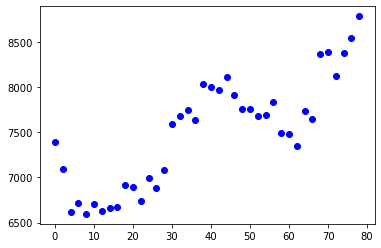

In [48]:
tau_start = 0
tau_end = 150
tau_step = 3
detuning = 20e6
tau_sweep = np.arange(tau_start, tau_end, tau_step)
ramsey_results = np.zeros(len(tau_sweep))

for idx, tau in enumerate(pulse_length_sweep):
    start = 0
    pihalf_pulse1 = Pulse(start=start, duration=pi_half_duration, amplitude=PULSE_AMPLITUDE, frequency=QUBIT_FREQUENCY + detuning,
                          phase=QUBIT_PHASE, shape=PULSE_SHAPE, channel=QUBIT_CHANNEL, qubit=QUBIT)
    
    start += tau + pi_half_duration
    pihalf_pulse2 = Pulse(start=start, duration=pi_half_duration, amplitude=PULSE_AMPLITUDE, frequency=QUBIT_FREQUENCY + detuning,
                          phase=QUBIT_PHASE, shape=PULSE_SHAPE, channel=QUBIT_CHANNEL, qubit=QUBIT)
    
    start += pi_half_duration
    ro_pulse = ReadoutPulse(start=start, duration=READOUT_DURATION, amplitude=PULSE_AMPLITUDE, frequency=READOUT_FREQUENCY,
                            phase=READOUT_PHASE, shape=PULSE_SHAPE, channel=READOUT_CHANNEL, qubit=QUBIT)
    ps = PulseSequence()
    ps.add(pihalf_pulse1)
    ps.add(pihalf_pulse2)
    ps.add(ro_pulse)

    res = platform.execute_pulse_sequence(ps, 2000)
    ramsey_results[idx] = res[0][0]
    plt.scatter(tau, res[0][0], color="blue")
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
pguess = [
    np.mean(ramsey_results),
    (max(ramsey)-min(ramsey)),
    1 / detuning / 1e-9,
    np.pi,
    10e3
    ]

popt, pcov = curve_fit(rabi, tau_sweep, ramsey_results, p0=pguess)
fit = rabi(tau_sweep, *popt)
plt.scatter(tau_sweep, ramsey_results, s=5, color="blue", label="Actual")
plt.plot(tau_sweep, fit, color="k", label="fit", linestyle='dashed')
plt.show()

In [ ]:
ramsey_frequency = 1 / (popt[2] * 1e-9)
QUBIT_FREQUENCY = QUBIT_FREQUENCY + detuning - ramsey_frequency

In [7]:
platform.disconnect()